<a href="https://colab.research.google.com/github/lucasjsbarbosa/reconhecimento-de-doencas-respiratorias-atraves-de-raios-x/blob/main/diagnostico_de_doen%C3%A7as_respirat%C3%B3rias_atrav%C3%A9s_de_raio_x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.models import load_model
from google.colab.patches import cv2_imshow

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
xray = '/content/drive/MyDrive/Departamento médico-20231102T045307Z-001/Departamento médico/Dataset'

In [29]:
os.listdir(xray)

['.DS_Store', '3', '0', '2', '1']

In [30]:
image_generator = ImageDataGenerator(rescale=1./255)

In [31]:
train_generator = image_generator.flow_from_directory(batch_size = 40, directory=xray,
                                                      shuffle =True, target_size=(256,256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [32]:
train_images, train_labels = next(train_generator)

In [33]:
train_images.shape

(40, 256, 256, 3)

In [34]:
train_labels

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [35]:
labels_names = {0 : 'Covid-19', 1 : 'Normal', 2 : 'Pneumonia viral', 3: 'Pneumonia bacteriana'}

## Visualização dos dados

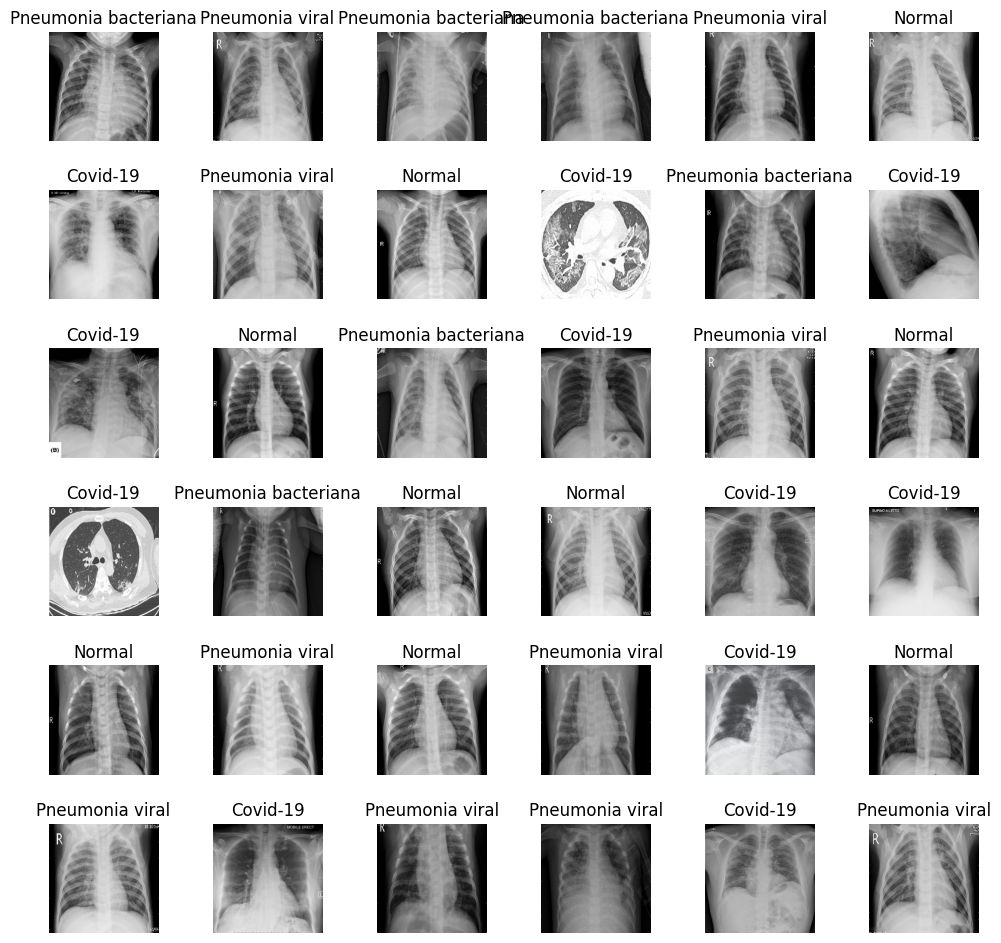

In [36]:
fig, axes = plt.subplots(6, 6, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_names[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## Rede Neural Pré-treinada

In [37]:
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

In [38]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [39]:
len(base_model.layers)

175

In [40]:
for layer in base_model.layers[:-10]:
  layers.trainable = False

## Construção e Treinamento do Modelo de Deep Learning




In [41]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(128, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [42]:
model = Model(inputs = base_model.input , outputs = head_model)

In [43]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr = 1e-4), metrics = ['accuracy'])

In [44]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [45]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory=xray,
                                                      shuffle =True, target_size=(256,256),
                                                      class_mode = 'categorical', subset='training')

Found 532 images belonging to 4 classes.


In [46]:
history = model.fit_generator(train_generator, epochs = 25, callbacks = [checkpointer])

<ipython-input-46-372be2f683ba>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs = 25, callbacks = [checkpointer])


Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 2.3504 - accuracy: 0.3703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 325s 2s/step - loss: 2.3504 - accuracy: 0.3703
Epoch 2/25
133/133 [==============================] - 315s 2s/step - loss: 1.2177 - accuracy: 0.5301
Epoch 3/25
133/133 [==============================] - 315s 2s/step - loss: 0.9847 - accuracy: 0.6598
Epoch 4/25
133/133 [==============================] - 322s 2s/step - loss: 0.8627 - accuracy: 0.7256
Epoch 5/25
133/133 [==============================] - 325s 2s/step - loss: 0.7966 - accuracy: 0.7312
Epoch 6/25
133/133 [==============================] - 324s 2s/step - loss: 0.6901 - accuracy: 0.7857
Epoch 7/25
133/133 [==============================] - 328s 2s/step - loss: 0.5793 - accuracy: 0.8252
Epoch 8/25
133/133 [==============================] - 331s 2s/step - loss: 0.4702 - accuracy: 0.8289
Epoch 9/25
133/133 [==============================] - 333s 3s/step - loss: 0.4589 - accuracy: 0.8759
Epoch 10/25
133/133 [==============================] - 341s 3s/step - loss: 0.4079 - accuracy: 0.8929


## Avaliação do *Modelo*

In [47]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

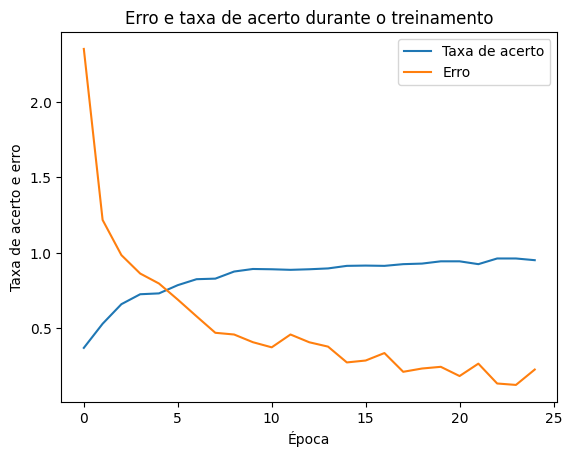

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto','Erro'])

In [79]:
test_directory = '/content/drive/MyDrive/Departamento médico-20231102T045307Z-001/Departamento médico/Test'

In [51]:
test_gen = ImageDataGenerator(rescale=1./255)
teste_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                               shuffle = True, target_size = (256,256,),
                                               class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [52]:
evaluate = model.evaluate_generator(teste_generator)

<ipython-input-52-1f9c31b732d7>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(teste_generator)


In [53]:
evaluate

[1.644676923751831, 0.7749999761581421]

In [56]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 175ms/step


In [57]:
accuracy_score(original, prediction)

0.75

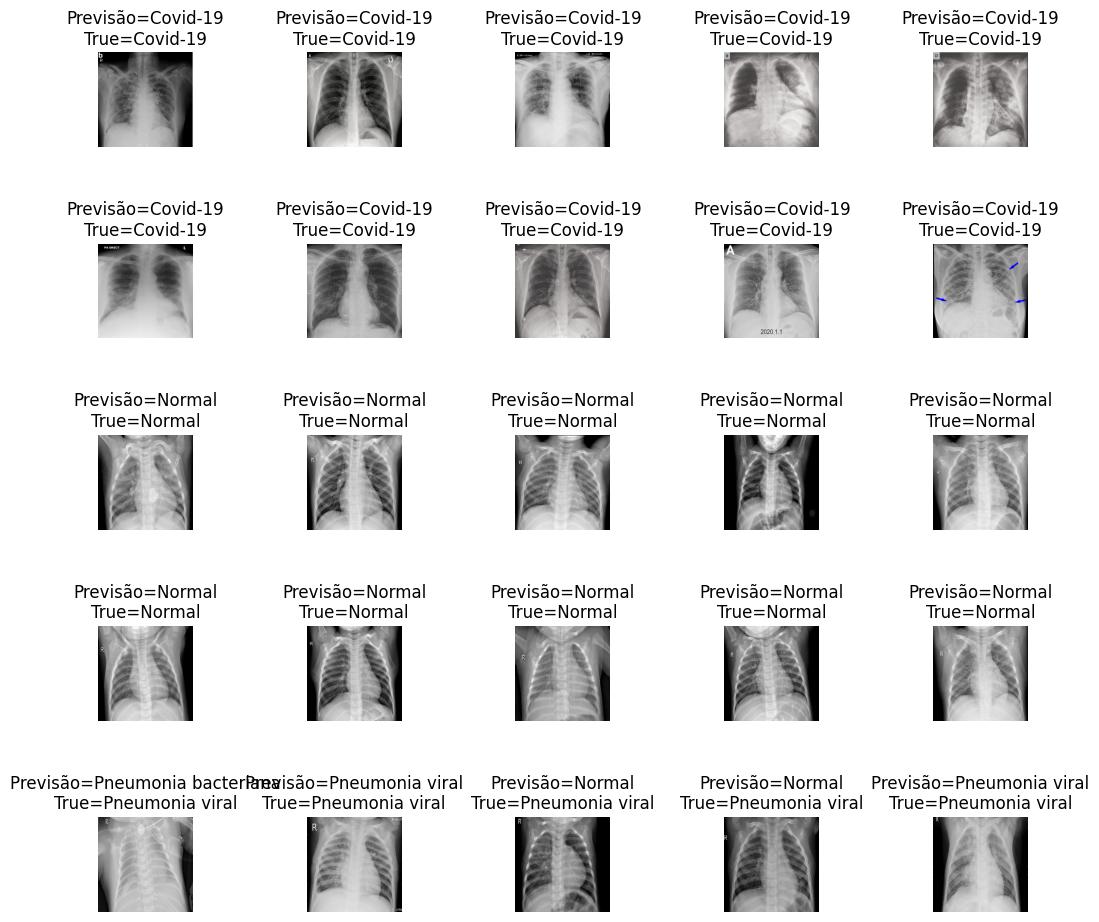

In [58]:
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace = 1.2)

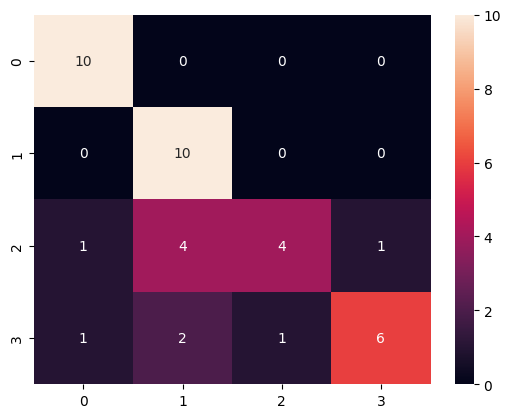

In [59]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [60]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        10
           1       0.62      1.00      0.77        10
           2       0.80      0.40      0.53        10
           3       0.86      0.60      0.71        10

    accuracy                           0.75        40
   macro avg       0.78      0.75      0.73        40
weighted avg       0.78      0.75      0.73        40



## Uso do modelo na prática

In [62]:
model_loaded = load_model('/content/weights.hdf5')

In [63]:
model_loaded.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [80]:
img = cv2.imread('/content/drive/MyDrive/Departamento médico-20231102T045307Z-001/Departamento médico/Test/0/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg')

In [81]:
img

array([[[253, 253, 253],
        [251, 251, 251],
        [250, 250, 250],
        ...,
        [250, 250, 250],
        [246, 246, 246],
        [255, 255, 255]],

       [[254, 254, 254],
        [252, 252, 252],
        [252, 252, 252],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [252, 252, 252]],

       [[169, 171, 171],
        [168, 170, 170],
        [167, 169, 169],
        ...,
        [164, 164, 164],
        [166, 166, 166],
        [214, 214, 214]],

       ...,

       [[ 91,  89,  89],
        [ 80,  78,  78],
        [ 96,  91,  92],
        ...,
        [ 81,  77,  76],
        [ 64,  62,  61],
        [175, 173, 172]],

       [[ 94,  92,  92],
        [ 80,  78,  78],
        [ 93,  88,  89],
        ...,
        [ 81,  77,  76],
        [ 64,  62,  61],
        [175, 173, 172]],

       [[ 98,  96,  96],
        [ 81,  79,  79],
        [ 91,  86,  87],
        ...,
        [ 81,  77,  76],
        [ 64,  62,  61],
        [175, 173, 172]]

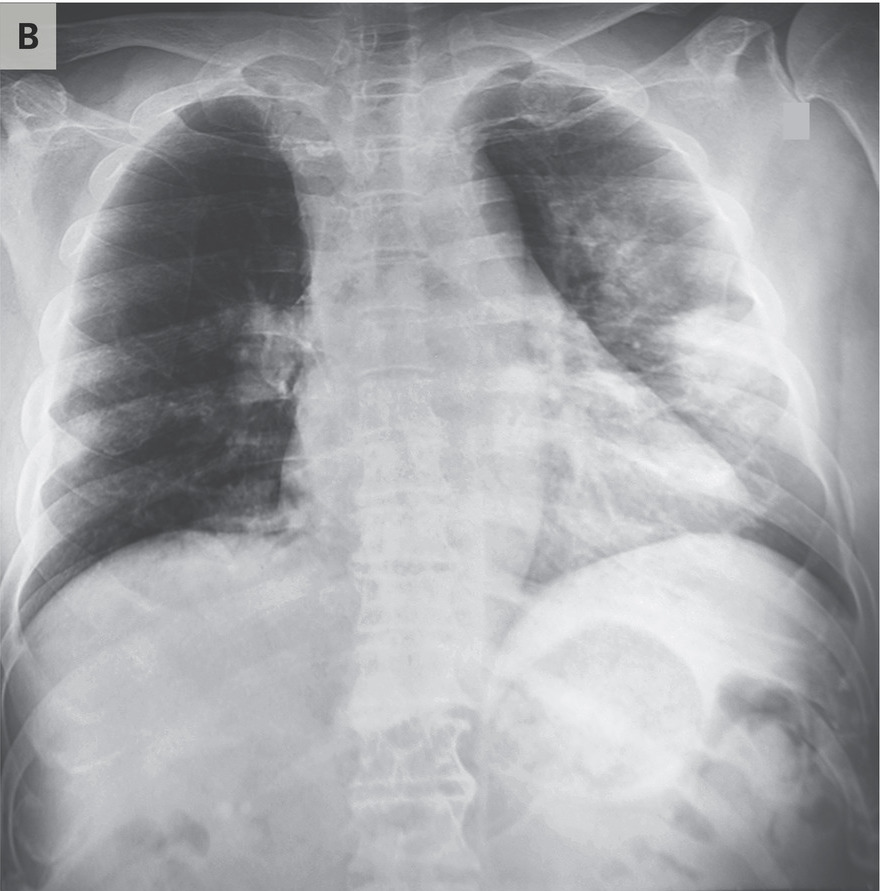

In [82]:
cv2_imshow(img)

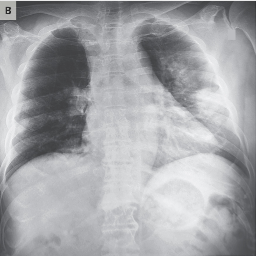

In [83]:
img = cv2.resize(img, (256,256))
cv2_imshow(img)

In [84]:
img = img / 255
img

array([[[0.90980392, 0.90980392, 0.90980392],
        [0.91764706, 0.91764706, 0.91764706],
        [0.91764706, 0.91764706, 0.91764706],
        ...,
        [0.91764706, 0.91764706, 0.91764706],
        [0.91372549, 0.91372549, 0.91372549],
        [0.91372549, 0.91372549, 0.91372549]],

       [[0.68235294, 0.69803922, 0.69411765],
        [0.69019608, 0.70588235, 0.70196078],
        [0.69019608, 0.70588235, 0.70196078],
        ...,
        [0.27058824, 0.2627451 , 0.2627451 ],
        [0.27058824, 0.2627451 , 0.2627451 ],
        [0.23137255, 0.21960784, 0.21960784]],

       [[0.68627451, 0.70588235, 0.70196078],
        [0.68235294, 0.70196078, 0.69803922],
        [0.68235294, 0.70196078, 0.69803922],
        ...,
        [0.26666667, 0.25882353, 0.25490196],
        [0.2627451 , 0.25490196, 0.25098039],
        [0.21960784, 0.21176471, 0.21176471]],

       ...,

       [[0.33333333, 0.31764706, 0.31372549],
        [0.34901961, 0.33333333, 0.32941176],
        [0.35294118, 0

In [85]:
img.shape

(256, 256, 3)

In [86]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [87]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0000000e+00, 8.2465116e-16, 2.7415488e-13, 2.0057033e-16]],
      dtype=float32)>

In [88]:
predict2 = np.argmax(predict)
predict2

0

In [89]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)